In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from random import shuffle
from sklearn.mixture import GaussianMixture
# The below 2 import are for the mincut maxflow alogrithm
import networkx
import maxflow
import math

In [2]:
img = cv2.imread('./images.jpeg')

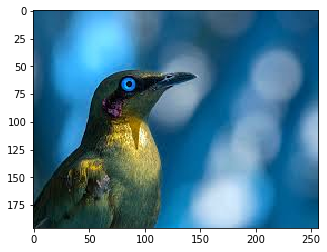

In [3]:
plt.imshow(img)
plt.show()

In [4]:
# region of intrest
r = cv2.selectROI(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
print(r)

(3, 45, 150, 151)


In [6]:
imCrop = img[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]

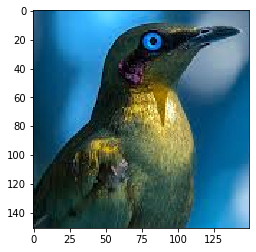

In [7]:
plt.imshow(imCrop)
plt.show()

In [8]:
mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

In [9]:
# cv2.grabCut(img,mask,r,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)

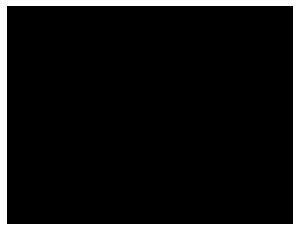

In [10]:
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img_1 = img*mask2[:,:,np.newaxis]


plt.axis("off")
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))
plt.show()

# plt.imshow(img_1),plt.colorbar(),plt.show()

In [11]:
# let me decide what is foreground and what is background

In [12]:
print(r)

(3, 45, 150, 151)


In [13]:
print(img.shape)
print(img_1.shape)
print(imCrop.shape)

(196, 257, 3)
(196, 257, 3)
(151, 150, 3)


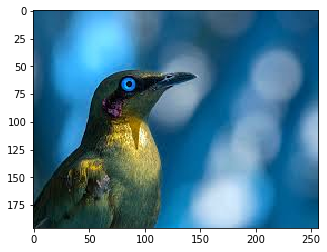

In [14]:
plt.imshow(img)
plt.show()

In [15]:
img_crop_1 = img.copy()
img_crop_1[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])] = 0

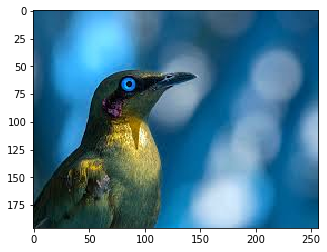

In [16]:
plt.imshow(img)
plt.show()

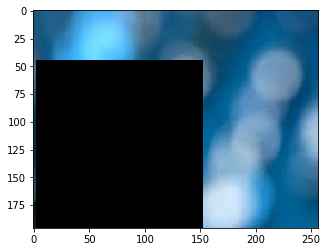

In [17]:
plt.imshow(img_crop_1)
plt.show()

In [18]:
def get_gmm(img,img_crop_1):

    foreground = []
    background = []
    foreground_cords = []
    background_cords = []

    count = 0
    for i in range(img_crop_1.shape[0]):
        for j in range(img_crop_1.shape[1]):
            val = sum(img_crop_1[i,j])
            if (val==0):
                count +=1
                foreground.append(img[i,j])
                foreground_cords.append([i,j])
            else:
                background.append(img[i,j])
                background_cords.append([i,j])

    foreground = np.asarray(foreground)
    background = np.asarray(background)
    
    print(foreground.shape,'foreground')
    print(background.shape,'background')
    
    return (foreground,background,foreground_cords,background_cords)

In [19]:
print(r[3], r[2])

151 150


In [20]:
# Fitting the gaussian mixture models
def fit_gmm(foreground,background):
    gmm_foreground = GaussianMixture(n_components=3).fit(foreground)
    gmm_background = GaussianMixture(n_components=3).fit(background)
    return(gmm_foreground,gmm_background)

In [21]:
def dist(x,y):
    return abs(x-y)

In [22]:
def beta(img):
    sum_val = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if ((i+1)<img.shape[0]):
                if((j+1)<img.shape[1]):
                    val_1 = (np.linalg.norm(img[i,j]-img[i+1,j]))**2
                    val_2 = (np.linalg.norm(img[i,j]-img[i,j+1]))**2
                    sum_val = val_1 + val_2
    
    beta_val = 1/ (2*(sum_val / (img.shape[0]*img.shape[1])))
    
    return beta_val    

In [23]:
# This is the part of maxflow_min_Cut algo
def get_graph(img,gmm_foreground,gmm_background,foreground_cords,background_cords,beta_val):
    g = maxflow.Graph[float]()

    # adding the nodes
    nodes = g.add_nodes(img.shape[0]*img.shape[1])

    a,b,c = img.shape
    
    max_weight = 0
    
    fore_ground_weights = gmm_foreground.weights_
    back_ground_weights = gmm_background.weights_
    print(beta_val,'beta_val')
    # inserting nodes into the graph
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if ((i+1)<img.shape[0]):
                if((j+1)<img.shape[1]):
                    # calculating the smoothness between the nodes
                    
                    
                    
                    graph_val = (50/dist(i*img.shape[1]+j,i+1*img.shape[1]+j)) * math.exp(-1 * beta_val *  abs(np.linalg.norm(img[i,j]-img[i+1,j])))
                    graph_val_1 = (50/dist(i*img.shape[1]+j,i*img.shape[1]+j+1)) * math.exp(-1 * beta_val *  abs(np.linalg.norm(img[i,j]-img[i,j+1])))
                    
                    
                    g.add_edge(nodes[i*img.shape[1]+j],nodes[(i+1*img.shape[1]+j)],graph_val,graph_val)
                    g.add_edge(nodes[i*img.shape[1]+j],nodes[(i*img.shape[1]+j+1)], graph_val_1,graph_val_1)


#             if([i,j] in background_cords):
#                         # background labels... fixed values as they are confirmed to be background
#                 g.add_tedge(nodes[i*320+j], 0, 10)

#             else:
                # not sure about the foreground values as there can be some background also
            val = np.asarray(img[i,j])
            val = np.reshape(val,[-1,3])

            pred = gmm_foreground.predict_proba(val)
            val_fore = fore_ground_weights[0]*pred[0,0] + fore_ground_weights[1]*pred[0,1] + fore_ground_weights[2]*pred[0,2]

            pred = gmm_background.predict_proba(val)
            val_back = back_ground_weights[0]*pred[0,0] + back_ground_weights[1]*pred[0,1] + back_ground_weights[2]*pred[0,2]

            if(val_fore > val_back):
                if(max_weight < val_fore):
                    max_weight = val_fore
                    
            else:
                if(max_weight < val_back):
                    max_weight = val_back
            
            g.add_tedge(nodes[i*img.shape[1]+j], -1 * math.log(val_fore), -1 * math.log(val_back))
            
    
    
    
#     for i in range(img.shape[0]):
#         for j in range(img.shape[1]):
#             if([i,j] in background_cords):
#                 g.add_tedge(nodes[i*img.shape[1]+j], max_weight, 0)
                
#     for i in range(img.shape[0]):
#         for j in range(img.shape[1]):
#             if([i,j] in foreground_cords):
#                 g.add_tedge(nodes[i*img.shape[1]+j],0, max_weight)
                
    print('nodes filled')
    return g,nodes

In [24]:
def get_segments(g,nodes):
    ind = []
    count = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            val = (g.get_segment(nodes[i*img.shape[1]+j]))
            ind.append(val)
            count +=1
    return (ind,count)

In [25]:
def img_seg_fun(img,ind):
    img_seg = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            val = ind[i,j]
            val_col = img[i,j] * val
            img_seg.append(val_col)
    
    img_seg = np.asarray(img_seg)

    img_seg = np.reshape(img_seg, [img.shape[0],img.shape[1],3])
    
    return img_seg

0 =============================================================================
(22650, 3) foreground
(27722, 3) background
8395.333333333334 beta_val
nodes filled


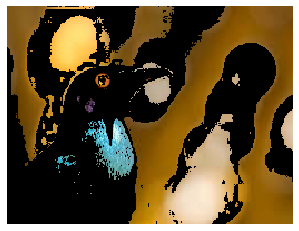

1 =============================================================================
(25466, 3) foreground
(24906, 3) background
8395.333333333334 beta_val
nodes filled


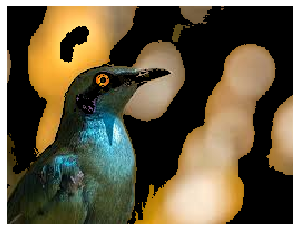

2 =============================================================================
(20115, 3) foreground
(30257, 3) background
8395.333333333334 beta_val
nodes filled


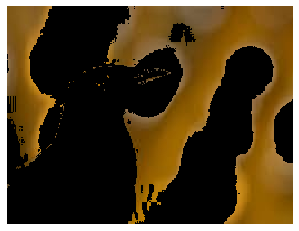

3 =============================================================================
(29149, 3) foreground
(21223, 3) background
8395.333333333334 beta_val
nodes filled


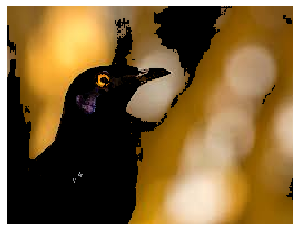

4 =============================================================================
(16481, 3) foreground
(33891, 3) background
8395.333333333334 beta_val
nodes filled


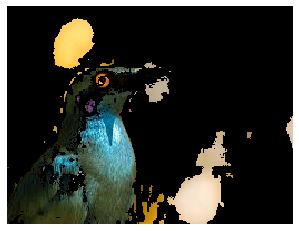

5 =============================================================================
(36965, 3) foreground
(13407, 3) background
8395.333333333334 beta_val
nodes filled


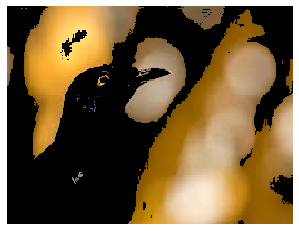

6 =============================================================================
(22859, 3) foreground
(27513, 3) background
8395.333333333334 beta_val
nodes filled


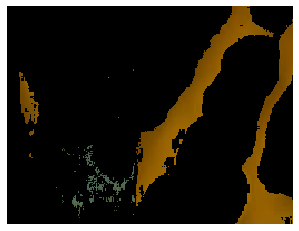

7 =============================================================================
(42545, 3) foreground
(7827, 3) background
8395.333333333334 beta_val
nodes filled


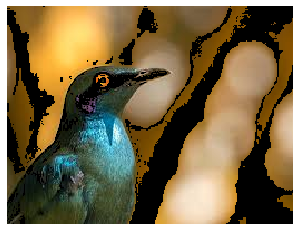

8 =============================================================================
(12103, 3) foreground
(38269, 3) background
8395.333333333334 beta_val
nodes filled


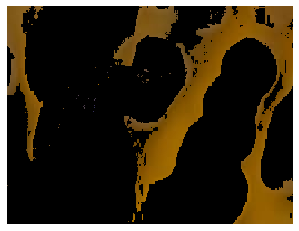

9 =============================================================================
(37682, 3) foreground
(12690, 3) background
8395.333333333334 beta_val
nodes filled


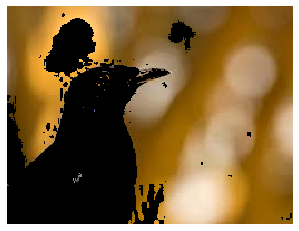

10 =============================================================================
(15269, 3) foreground
(35103, 3) background
8395.333333333334 beta_val
nodes filled


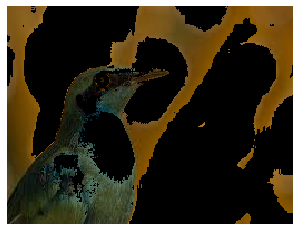

11 =============================================================================
(29647, 3) foreground
(20725, 3) background
8395.333333333334 beta_val
nodes filled


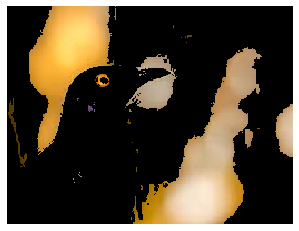

12 =============================================================================
(35819, 3) foreground
(14553, 3) background
8395.333333333334 beta_val
nodes filled


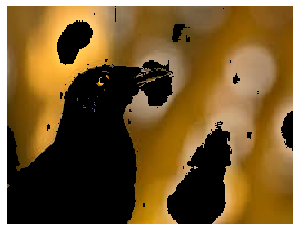

13 =============================================================================
(17283, 3) foreground
(33089, 3) background
8395.333333333334 beta_val
nodes filled


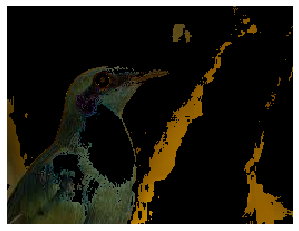

14 =============================================================================
(37833, 3) foreground
(12539, 3) background
8395.333333333334 beta_val
nodes filled


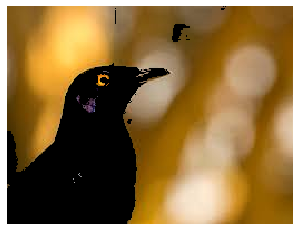

15 =============================================================================
(12089, 3) foreground
(38283, 3) background
8395.333333333334 beta_val
nodes filled


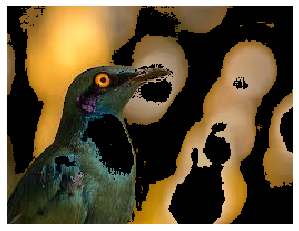

16 =============================================================================
(20394, 3) foreground
(29978, 3) background
8395.333333333334 beta_val
nodes filled


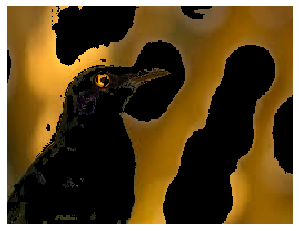

17 =============================================================================
(23621, 3) foreground
(26751, 3) background
8395.333333333334 beta_val
nodes filled


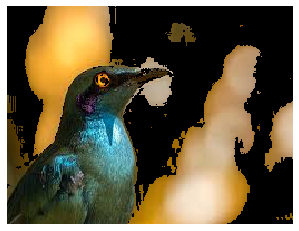

18 =============================================================================
(20818, 3) foreground
(29554, 3) background
8395.333333333334 beta_val
nodes filled


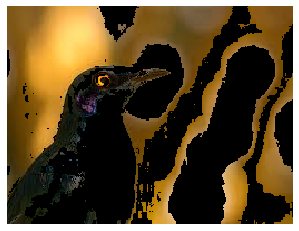

19 =============================================================================
(24160, 3) foreground
(26212, 3) background
8395.333333333334 beta_val
nodes filled


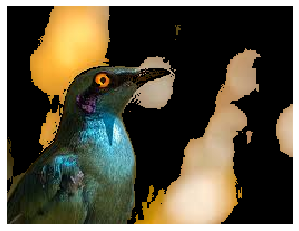

20 =============================================================================
(25700, 3) foreground
(24672, 3) background
8395.333333333334 beta_val
nodes filled


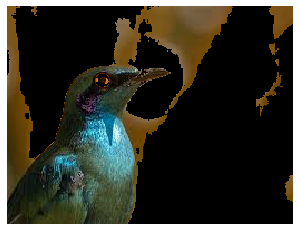

21 =============================================================================
(30825, 3) foreground
(19547, 3) background
8395.333333333334 beta_val
nodes filled


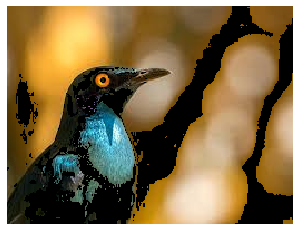

22 =============================================================================
(12563, 3) foreground
(37809, 3) background
8395.333333333334 beta_val
nodes filled


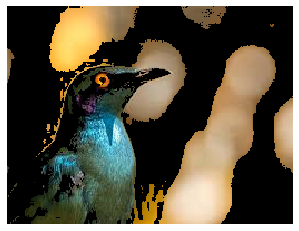

23 =============================================================================
(26723, 3) foreground
(23649, 3) background
8395.333333333334 beta_val
nodes filled


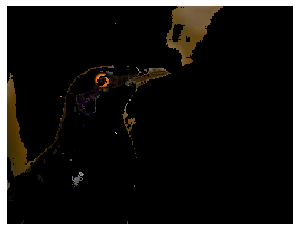

24 =============================================================================
(46698, 3) foreground
(3674, 3) background
8395.333333333334 beta_val
nodes filled


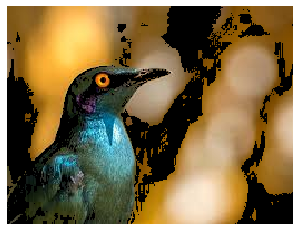

25 =============================================================================
(12663, 3) foreground
(37709, 3) background
8395.333333333334 beta_val
nodes filled


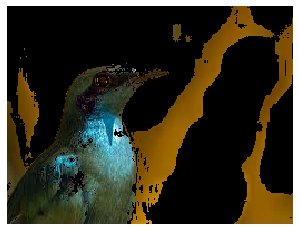

26 =============================================================================
(29518, 3) foreground
(20854, 3) background
8395.333333333334 beta_val
nodes filled


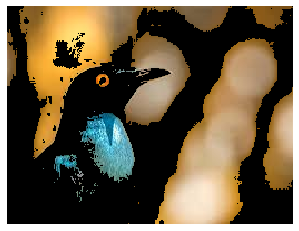

27 =============================================================================
(25832, 3) foreground
(24540, 3) background
8395.333333333334 beta_val
nodes filled


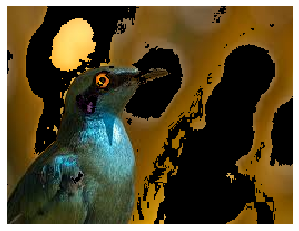

28 =============================================================================
(18541, 3) foreground
(31831, 3) background
8395.333333333334 beta_val
nodes filled


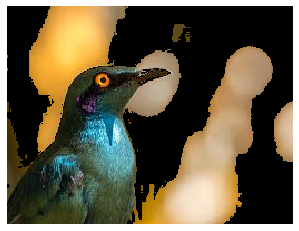

29 =============================================================================
(21496, 3) foreground
(28876, 3) background
8395.333333333334 beta_val
nodes filled


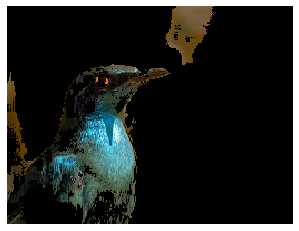

In [26]:
beta_val = beta(img)
for i in range(30):
    print(i,'=============================================================================')
    foreground,background,foreground_cords,background_cords = get_gmm(img,img_crop_1)
    gmm_foreground,gmm_background = fit_gmm(foreground,background)
    g,nodes = get_graph(img,gmm_foreground,gmm_background,foreground_cords,background_cords,beta_val)
    flow = g.maxflow()
    
    ind,count = get_segments(g,nodes)
    ind = np.asanyarray(ind)

    ind = np.reshape(ind,[img.shape[0],img.shape[1]])

    img_seg = img_seg_fun(img,ind)

    
    plt.axis("off")
    plt.imshow(cv2.cvtColor(img_seg, cv2.COLOR_BGR2RGB))
    plt.show()
        
    img_crop_1 = img_seg